<a href="https://colab.research.google.com/github/mferri17/amazon-reviews-sentiment-network-analysis/blob/master/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews Sentiment Analysis - Ferri Marco, Basso Matteo

This project aims to experiment with sentiment analysis on [Amazon Reviews](http://jmcauley.ucsd.edu/data/amazon/) in order to build a "rating" prediction model based on text analysis.

## Dataset

### Dependencies

In [0]:
import os
import gzip
import fileinput
import sys
import datetime
import io
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading


Util functions to read from JSON and convert into pandas dataframe:

In [0]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):      
  basepath = r"datasets\amazon-5-core"
  df = getDF(os.path.join(basepath, dataset))
  return df
  
def download_dataset(dataset):
  request = urllib.request.Request('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/' + dataset)
  request.add_header('Accept-encoding', 'gzip')
  response = urllib.request.urlopen(request)
  buf = io.BytesIO(response.read())
  file = gzip.GzipFile(fileobj=buf)
  df = []
  for line in file:
    df.append(eval(line))
  return pd.DataFrame(df)

Reading from JSON

In [5]:
#%time dfull = read_dataset("reviews_Video_Games_5.json.gz")
%time dfull = download_dataset('reviews_Sports_and_Outdoors_5.json.gz')

CPU times: user 16.1 s, sys: 942 ms, total: 17.1 s
Wall time: 35 s


#### Reading performance

!pip install py-heat-magic
%load_ext heat

%%heat
import os
import gzip
import fileinput
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):
    basepath = r"datasets\amazon-5-core"
    df = getDF(os.path.join(basepath, dataset))
    return df

dfull = read_dataset("reviews_Video_Games_5.json.gz")

![reading performances](https://github.com/mferri17/amazon-reviews-sentiment-network-analysis/blob/master/docs/images/00_dataset_reading_performances.png?raw=true)

---

###  Description

#### Schema

In [6]:
print("(rows, cols) = ", dfull.shape)

(rows, cols) =  (296337, 9)


In [0]:
dfull = dfull.rename(index=str, columns={"asin": "productID", 
                                         "reviewerID": "userID", 
                                         "reviewerName": "userName",
                                         "reviewText": "text",
                                         "overall": "rating"})

In [8]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296337 entries, 0 to 296336
Data columns (total 9 columns):
productID         296337 non-null object
helpful           296337 non-null object
rating            296337 non-null float64
text              296337 non-null object
reviewTime        296337 non-null object
userID            296337 non-null object
userName          294935 non-null object
summary           296337 non-null object
unixReviewTime    296337 non-null int64
dtypes: float64(1), int64(1), object(7)
memory usage: 22.6+ MB


In [9]:
dfull.head(3)

,productID,helpful,rating,text,reviewTime,userID,userName,summary,unixReviewTime
0,1881509818,"[0, 0]",5.0,This came in on time and I am veru happy with ...,"01 26, 2014",AIXZKN4ACSKI,David Briner,Woks very good,1390694400
1,1881509818,"[1, 1]",5.0,I had a factory Glock tool that I was using fo...,"02 2, 2012",A1L5P841VIO02V,Jason A. Kramer,Works as well as the factory tool,1328140800
2,1881509818,"[2, 2]",4.0,If you don't have a 3/32 punch or would like t...,"02 28, 2012",AB2W04NI4OEAD,J. Fernald,"It's a punch, that's all.",1330387200


#### Columns analysis

##### Users and products

In [10]:
(rows,cols) = dfull.shape
n_users = dfull['userID'].nunique()
n_products = dfull['productID'].nunique()
print("Number of REVIEWS: ", rows)
print("Number of USERS: ", n_users)
print("Number of PRODUCTS: ", n_products)
print("Avarage REVIEWS PER USER: ", rows/n_users)
print("Avarage REVIEWS PER PRODUCT: ", rows/n_products)

Number of REVIEWS:  296337
Number of USERS:  35598
Number of PRODUCTS:  18357
Avarage REVIEWS PER USER:  8.324540704533963
Avarage REVIEWS PER PRODUCT:  16.142997221768262


##### Datetime

In [11]:
dfull['date'] = pd.to_datetime(dfull['unixReviewTime'],unit='s')
print("First date: ", min(dfull['date']))
print("Last date: ", max(dfull['date']))

First date:  2002-03-07 00:00:00
Last date:  2014-07-23 00:00:00


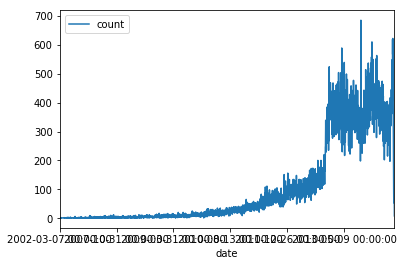

In [12]:
date_grouping = dfull.groupby('date').count()[['rating']].sort_values('date', ascending=True)
date_grouping = date_grouping.rename(index=str, columns={"rating": "count"})
date_grouping.plot()

##### Rating

In [13]:
print("Average rating: ", dfull['rating'].mean())

Average rating:  4.393450699710128


Rating distribution


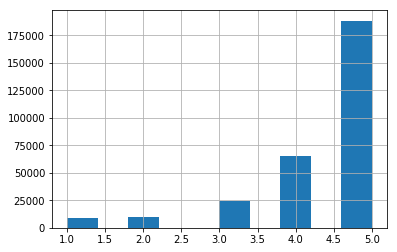

In [14]:
print("Rating distribution")
dfull['rating'].hist()

### Manipulation

#### Rejecting columns

In [0]:
dfull = dfull.drop(['helpful', 'reviewTime', 'unixReviewTime', 'userName'], axis = 1)

#### Binarization

In [16]:
dfull['sentiment'] = ['positive' if r > 3 else 'negative' for r in dfull['rating']]

print("Sentiment count")
dfull['sentiment'].value_counts()

Sentiment count


positive    253017
negative     43320
Name: sentiment, dtype: int64

***

## Sentiment Analysis

### Dependencies

In [17]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

from PIL import Image
from wordcloud import WordCloud

from collections import Counter
import itertools


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Text pre-processing

**Tokenizer**

Default tokenizers have weird behaviour with puntctuation, numbers and english contractions, hence a custom Regex-based tokenizer has been chosen. Working example below.

In [0]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[^\d\W][\w\']*') # preserve alphabetic words (not numbers) and contractions

**Stop words**

The original stopwords list from NLTK is too aggresive for this use case. Then, stopwords list has been customized with the words below.

Words "not" and "but" are not included in the list, because they could be important to determine negative class membership.

In [19]:
#stopset = set(stopwords.words('english')) # too aggressive

stopset = {
    'a', 'ain', 'and', 'any', 'are', 'as', 'at', 
    'be', 'because', 'being', 'between', 'both', 'by', 
    'doing', 'during', 'each', 'few', 'for', 'from', 'further', 
    'has', 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 
    'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 
    'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'my', 'myself', 
    'now', 'o', 'of', 'off', 'on', 'once', 'or', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 
    're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'so', 'some', 'such', 
    't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 
    'there', 'these', 'they', 'this', 'those', 'through', 'to', 'until', 'up', 've', 
    'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'with', 
    'y', 'you', "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'}

print("Stopwords: ", list(stopset))

Stopwords:  ['through', 'being', "should've", 'have', 'were', 'just', 'me', 'from', 'you', 'she', 'which', "she's", 'they', 'themselves', 'm', 'himself', 'him', 'it', 'doing', 'to', 'because', 'out', 'your', 'should', 'such', 'off', 'yourselves', 's', "it's", 'there', 'into', 'now', 'itself', 'when', 'by', 'on', 'own', 'those', 'than', 'he', 'ourselves', 'same', 'their', 'each', 'is', 'its', 'be', 'this', 'if', 'of', 'any', 'has', 'whom', 'having', 'are', 'or', 'his', 'll', 'then', 'with', 'our', 'myself', 't', "that'll", 'what', 'further', 'y', 'both', 'the', 'we', 'a', 'that', 'o', 'haven', 'yourself', 'here', 'as', 've', 'them', 'i', 'was', 'and', 'at', 'for', 'once', 'who', 'up', 'in', 'these', "you're", 'during', 'ain', "you've", 'so', 'between', "shan't", "haven't", 'some', 'herself', 'yours', 're', 'over', 'theirs', 'her', 'how', 'my', 'where', 'why', 'until', 'ma', 'shan', 'while', 'few', 'hers', 'ours']


**Stemmer**

The default english stemmer is enough for this use case. However, on large datasets it requires too much RAM and that is why it will not probably be used.

In [0]:
stemmer = SnowballStemmer('english')

**Full example**

In [21]:
print("TEXT ANALYSIS EXAMPLE")

text = "Hi! This... isn't a beautiful sentence with some interesting $70 and €5,50 features like people's names and Mr. Fox thoughts for number such as 23, 4 and 7 or peer2peer and wi-fi with snake_case but not kebab-case."
print("Text:\t\t", text) # original

# tokenizing
tokens = tokenizer.tokenize(text)
print("Tokenized:\t", tokens)

# lowercasing
tokens = [t.lower() for t in tokens] 
print("Lowercased:\t", tokens)

# removing stopwords
tokens = [t for t in tokens if not t in stopset]  
print("No stopwords:\t", tokens)

# stemming
tokens = [stemmer.stem(t) for t in tokens]
print("Stemmed:\t", tokens)

TEXT ANALYSIS EXAMPLE
Text:		 Hi! This... isn't a beautiful sentence with some interesting $70 and €5,50 features like people's names and Mr. Fox thoughts for number such as 23, 4 and 7 or peer2peer and wi-fi with snake_case but not kebab-case.
Tokenized:	 ['Hi', 'This', "isn't", 'a', 'beautiful', 'sentence', 'with', 'some', 'interesting', 'and', 'features', 'like', "people's", 'names', 'and', 'Mr', 'Fox', 'thoughts', 'for', 'number', 'such', 'as', 'and', 'or', 'peer2peer', 'and', 'wi', 'fi', 'with', 'snake_case', 'but', 'not', 'kebab', 'case']
Lowercased:	 ['hi', 'this', "isn't", 'a', 'beautiful', 'sentence', 'with', 'some', 'interesting', 'and', 'features', 'like', "people's", 'names', 'and', 'mr', 'fox', 'thoughts', 'for', 'number', 'such', 'as', 'and', 'or', 'peer2peer', 'and', 'wi', 'fi', 'with', 'snake_case', 'but', 'not', 'kebab', 'case']
No stopwords:	 ['hi', "isn't", 'beautiful', 'sentence', 'interesting', 'features', 'like', "people's", 'names', 'mr', 'fox', 'thoughts', 'numb

**Processing dataset**

Variable `predictions_field` contains "summary" or "text", depending on the column chosen later on for machine learning predictions.

In [22]:
pd.set_option('display.max_columns', 150)


def text_processing(field):
  normalized = dfull[field]
  normalized = normalized.apply(tokenizer.tokenize)
  normalized = normalized.apply(lambda tokens_list: [token.lower() for token in tokens_list])
  normalized = normalized.apply(lambda tokens_list: [token for token in tokens_list if token not in stopset])
  #normalized = normalized.apply(lambda tokens_list: [stemmer.stem(token) for token in tokens_list])
  return normalized
  
predictions_field = 'summary'
%time normalized_field = text_processing(predictions_field)

CPU times: user 2.71 s, sys: 158 ms, total: 2.87 s
Wall time: 2.87 s


In [23]:
dfull[predictions_field + '_tokens'] = normalized_field
dfull[predictions_field + '_normalized'] = normalized_field.apply(lambda tokens_list: ' '.join(tokens_list))
dfull.head(5)

,productID,rating,text,userID,summary,date,sentiment,summary_tokens,summary_normalized
0,1881509818,5.0,This came in on time and I am veru happy with ...,AIXZKN4ACSKI,Woks very good,2014-01-26,positive,"[woks, very, good]",woks very good
1,1881509818,5.0,I had a factory Glock tool that I was using fo...,A1L5P841VIO02V,Works as well as the factory tool,2012-02-02,positive,"[works, well, factory, tool]",works well factory tool
2,1881509818,4.0,If you don't have a 3/32 punch or would like t...,AB2W04NI4OEAD,"It's a punch, that's all.",2012-02-28,positive,"[punch, that's, all]",punch that's all
3,1881509818,4.0,This works no better than any 3/32 punch you w...,A148SVSWKTJKU6,It's a punch with a Glock logo.,2012-02-05,positive,"[punch, glock, logo]",punch glock logo
4,1881509818,4.0,I purchased this thinking maybe I need a speci...,AAAWJ6LW9WMOO,"Ok,tool does what a regular punch does.",2013-04-23,positive,"[ok, tool, does, regular, punch, does]",ok tool does regular punch does


### Common Words

In [0]:
# sentences = (list(itertools.chain(dfull)))
# flat_list = [item for sublist in sentences for item in sublist]
  
# fig = plt.figure(figsize=(20,14))
# wordcloud = WordCloud(background_color="white").generate(" ".join(flat_list))
# plt.imshow(wordcloud,interpolation='bilinear')
# plt.axis("off")



---



## Machine Learning

### Undersampling

As previously seen, target column (`rating`) is strongly unbalanced towards the positive class. Undersampling of the majority class is necessary here to achieve good machine learning preformances later on. This mainly afftects *recall* of testes prediction models.

In [48]:
from sklearn.utils import *

# Separate majority and minority classes
positive_count = dfull['sentiment'].value_counts()['positive']
negative_count = dfull['sentiment'].value_counts()['negative']
df_majority = dfull[dfull.sentiment==('positive' if positive_count >= negative_count else 'negative')]
df_minority = dfull[dfull.sentiment==('negative' if positive_count >= negative_count else 'positive')]
 
# Downsample majority class
obj_samples = negative_count if positive_count >= negative_count else positive_count
df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples = obj_samples, # match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print("Positive/negative distribution post-undersampling")
df_downsampled['sentiment'].value_counts()

Positive/negative distribution post-undersampling


positive    43320
negative    43320
Name: sentiment, dtype: int64

### TF-IDF (term frequency - inverse document frequency)

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect **how important a word is to a document in a collection or corpus**. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today.

\- Wikipedia

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_downsampled = df_downsampled.drop(['rating'], axis = 1) # directly infers sentiment

tvec = TfidfVectorizer(use_idf=True,
                       strip_accents=None,
                       stop_words=None,
                       lowercase=False) # Tf-idf settings

actuals = df_downsampled.sentiment
tfidf = tvec.fit_transform(df_downsampled[predictions_field + '_normalized']) # learning vocabulary and idf

print("(rows,) \t=", actuals.shape) # actual target
print("(rows, terms)\t=", tfidf.shape) # Tf-idf-weighted document-term matrix

(rows,) 	= (86640,)
(rows, terms)	= (86640, 15123)


### Term Weights

Common terms have higher weights in the resulting Tf-idf-weighted document-term matrix. If a term appears to be very frequent but not much significant, then it should be inserted in the stopwords list.

In [93]:
print("Most common terms weights")
weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

Most common terms weights


,term,weight
5559,great,0.044849
5455,good,0.034516
8729,not,0.031376
14822,works,0.021034
1745,but,0.020693
8625,nice,0.017409
8877,ok,0.016891
9993,product,0.015933
9926,price,0.013778
14288,very,0.013346


### Splitting training and test set

Altough *Tf-idf-weighted document-term matrix* is learnt on the whole dataset, ML models must be run on splitted dataset for training and testing porposes.

In [0]:
tfidf_train, tfidf_test, actuals_train, actuals_test = train_test_split(tfidf, actuals, test_size = 0.3, shuffle = True)

### Models

Several machine learning models will be tried out to predict `rating` from review `summary` or `text`.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer

from sklearn import naive_bayes
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier



def roc_and_auc(model):  
  
  fpr, tpr, thresholds = metrics.roc_curve(actuals_test, model.predict_proba(tfidf_test)[:,1], pos_label = 'positive')

  pred_probs = model.predict_proba(tfidf_test)[:,1] # prediction probabilities for positive class
  auc = metrics.roc_auc_score(actuals_test, pred_probs)
  
  plt.figure()
  plt.plot(fpr, tpr, label = 'AUROC = %0.4f' % auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.title('ROC Curve')
    

    
    
def run_model(model, folds = 10):
  
  print(model)
  print()
  
  # LEARNING AND PREDICTION
  
  model.fit(tfidf_train, actuals_train)
  predictions = model.predict(tfidf_test)
  
  
  # CROSS VALIDATION
  
  df_confusion = pd.crosstab(actuals_test, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
  print("Confusion matrix\n", df_confusion)
  
  cm = metrics.confusion_matrix(actuals_test, predictions)
  plt.matshow(cm)
  plt.title('Confusion matrix')
  plt.colorbar()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  
  print("\n METRICS")
  print(metrics.classification_report(actuals_test, predictions))
  
  
  # ROC/AUC
  roc_and_auc(model)
  
  
  # CROSS VALIDATION
  
  print()
  accuracy = cross_val_score(model, tfidf, actuals, cv=folds, scoring='accuracy')
#   precision = cross_val_score(model, tfidf, actuals, cv=folds, scoring='precision')
#   recall = cross_val_score(model, tfidf, actuals, cv=folds, scoring='recall')
  print("ACCURACY ON ", folds, "FOLD CROSS VALIDATION: ", accuracy.mean())
#   print("PRECISION ON ", folds, "FOLD CROSS VALIDATION: ", precision.mean())
#   print("RECALL ON ", folds, "FOLD CROSS VALIDATION: ", recall.mean())
  
  print("\n")

#### Naive Bayes

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Confusion matrix
 Predicted  negative  positive    All
Actual                              
negative      10019      2904  12923
positive       2576     10493  13069
All           12595     13397  25992


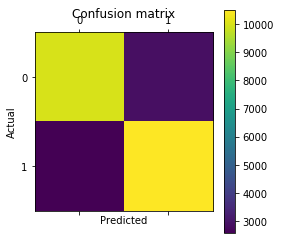


 METRICS
              precision    recall  f1-score   support

    negative       0.80      0.78      0.79     12923
    positive       0.78      0.80      0.79     13069

    accuracy                           0.79     25992
   macro avg       0.79      0.79      0.79     25992
weighted avg       0.79      0.79      0.79     25992


ACCURACY ON  10 -FOLD CROSS VALIDATION:  0.7892313019390581


CPU times: user 3.96 s, sys: 192 ms, total: 4.15 s
Wall time: 3.94 s


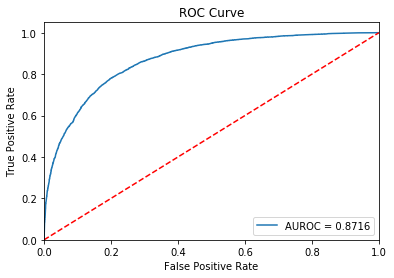

In [96]:
  bayes = naive_bayes.MultinomialNB()
  %time run_model(bayes)

#### SVM

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Confusion matrix
 Predicted  negative  positive    All
Actual                              
negative      10396      2527  12923
positive       2563     10506  13069
All           12959     13033  25992


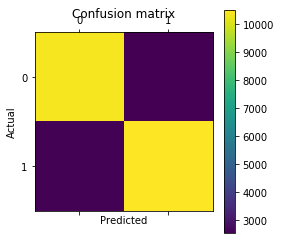


 METRICS
              precision    recall  f1-score   support

    negative       0.80      0.80      0.80     12923
    positive       0.81      0.80      0.80     13069

    accuracy                           0.80     25992
   macro avg       0.80      0.80      0.80     25992
weighted avg       0.80      0.80      0.80     25992


ACCURACY ON  10 -FOLD CROSS VALIDATION:  0.8039127423822714


CPU times: user 4.68 s, sys: 1.16 s, total: 5.83 s
Wall time: 4.33 s


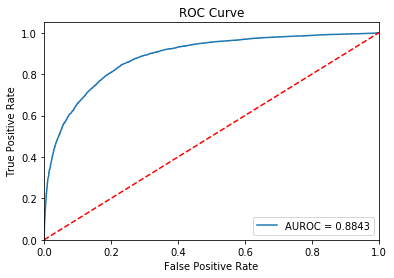

In [97]:
svm = SGDClassifier(loss='log')
%time run_model(svm)

#### Random Forest

Random Forest is slow and performs worse than the other models.

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Confusion matrix
 Predicted  negative  positive    All
Actual                              
negative      10892      2031  12923
positive       3677      9392  13069
All           14569     11423  25992


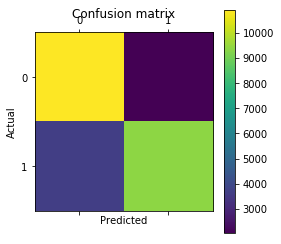


 METRICS
              precision    recall  f1-score   support

    negative       0.75      0.84      0.79     12923
    positive       0.82      0.72      0.77     13069

    accuracy                           0.78     25992
   macro avg       0.78      0.78      0.78     25992
weighted avg       0.79      0.78      0.78     25992


ACCURACY ON  10 -FOLD CROSS VALIDATION:  0.7845683287165282


CPU times: user 3min, sys: 338 ms, total: 3min
Wall time: 3min


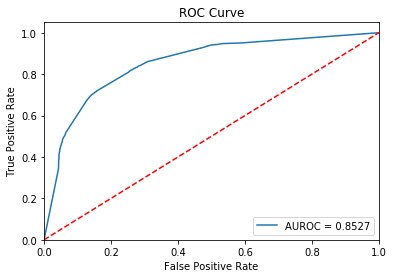

In [98]:
#forest = RandomForestClassifier(n_estimators = 4) # default n_estimators is 10
#%time run_model(forest)

---